In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

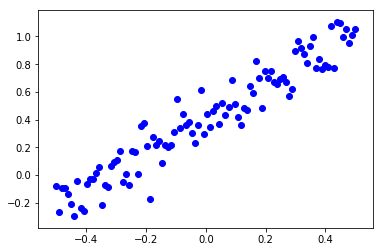

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [3]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[ 0.26301852]])
b: variable b([ 0.])
Operations on chainer.Variable: variable([[ 123.26301575]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[ 0.26301852]] [[ 123.26301575]]


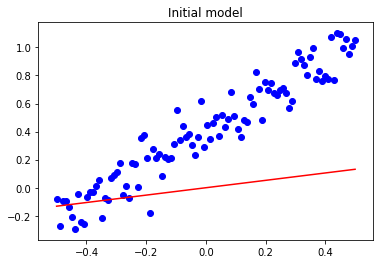

In [4]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [5]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.2617785334587097)
dloss/dW [[-0.16712697]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.20220519602298737)
Itr 25 loss: variable(0.021838046610355377)
Itr 50 loss: variable(0.01632477529346943)
Itr 75 loss: variable(0.013986889272928238)


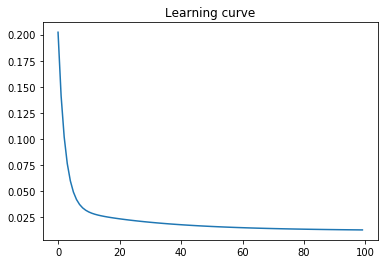

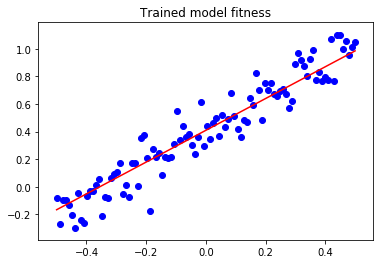

In [10]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

lr = 0.1

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    model.W.data -= lr*model.W.grad
    model.b.data -= lr*model.b.grad
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


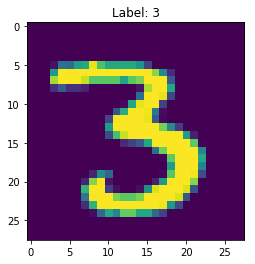

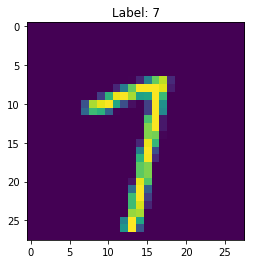

In [11]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [12]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0625; loss: 2.32046127319
accuracy: 0.82; loss: 0.67633217454
accuracy: 0.9025; loss: 0.431563625932
accuracy: 0.8725; loss: 0.436200680137
accuracy: 0.8875; loss: 0.416910642982
accuracy: 0.9125; loss: 0.324158379734
accuracy: 0.9025; loss: 0.37119664818
accuracy: 0.8925; loss: 0.398179800808
accuracy: 0.92; loss: 0.327991143167
accuracy: 0.915; loss: 0.294581488669
accuracy: 0.915; loss: 0.251825500131
accuracy: 0.9325; loss: 0.28893787384
accuracy: 0.9125; loss: 0.343733860552
accuracy: 0.92; loss: 0.315376929939
accuracy: 0.9475; loss: 0.244635521173
accuracy: 0.9325; loss: 0.255046423227
accuracy: 0.92; loss: 0.273771564662
accuracy: 0.935; loss: 0.303561233878
accuracy: 0.9125; loss: 0.336780593395
accuracy: 0.935; loss: 0.288008983731
accuracy: 0.94; loss: 0.228321945965
accuracy: 0.9075; loss: 0.318285391927
accuracy: 0.9375; loss: 0.268234203756
accuracy: 0.9175; loss: 0.29458026439
accuracy: 0.9175; loss: 0.291807190478
accuracy: 0.9125; loss: 0.301603880227


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [14]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
run(MLP(200, 10))

accuracy: 0.0625; loss: 2.31594276428
accuracy: 0.9175; loss: 0.266508683562
accuracy: 0.9325; loss: 0.19411064744
accuracy: 0.9275; loss: 0.25324193716
accuracy: 0.9325; loss: 0.209913341105
accuracy: 0.945; loss: 0.177825641036
accuracy: 0.9575; loss: 0.141109347939
accuracy: 0.9475; loss: 0.15408366859
accuracy: 0.97; loss: 0.117115167677
accuracy: 0.9575; loss: 0.0909008306265
accuracy: 0.97; loss: 0.111247750521
accuracy: 0.955; loss: 0.137013470531
accuracy: 0.9725; loss: 0.0714947903156
accuracy: 0.9625; loss: 0.113363589048
accuracy: 0.98; loss: 0.0709389805794
accuracy: 0.975; loss: 0.0889854925871
accuracy: 0.985; loss: 0.0516876414418
accuracy: 0.9675; loss: 0.138806474209
accuracy: 0.955; loss: 0.124097278714
accuracy: 0.97; loss: 0.0737819629908
accuracy: 0.9725; loss: 0.0771839380264
accuracy: 0.9825; loss: 0.0438422170281
accuracy: 0.9675; loss: 0.0992624759674
accuracy: 0.965; loss: 0.122117995024
accuracy: 0.9675; loss: 0.115024679601
accuracy: 0.9825; loss: 0.07305438

Next you should try to implement logging test loss and see if the model is overfitting.

In [24]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                # test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                xs = np.concatenate([datum[0][None, :] for datum in test])
                ys = np.array([datum[1] for datum in test])
                logits = model(xs)
                stats["test_accuracy"] = F.accuracy(logits, ys).data
                stats["test_loss"] = F.softmax_cross_entropy(logits, ys).data
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

test_loss: 2.28831; accuracy: 0.1875; loss: 2.23641705513; test_accuracy: 0.1232
test_loss: 0.314889; accuracy: 0.8825; loss: 0.375114524364; test_accuracy: 0.9061
test_loss: 0.220765; accuracy: 0.9425; loss: 0.202896259427; test_accuracy: 0.9315
test_loss: 0.207392; accuracy: 0.9425; loss: 0.176324358881; test_accuracy: 0.9352
test_loss: 0.221745; accuracy: 0.9525; loss: 0.192280195653; test_accuracy: 0.9293
test_loss: 0.165214; accuracy: 0.955; loss: 0.141820861697; test_accuracy: 0.9485
test_loss: 0.140204; accuracy: 0.9525; loss: 0.180047000051; test_accuracy: 0.9579
test_loss: 0.134326; accuracy: 0.96; loss: 0.147384900451; test_accuracy: 0.9601
test_loss: 0.130313; accuracy: 0.955; loss: 0.167229895592; test_accuracy: 0.9609
test_loss: 0.120142; accuracy: 0.9625; loss: 0.115275173485; test_accuracy: 0.9624
test_loss: 0.105237; accuracy: 0.97; loss: 0.0883056977391; test_accuracy: 0.9661
test_loss: 0.128996; accuracy: 0.9625; loss: 0.135939595103; test_accuracy: 0.9601
test_loss: 

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc